# General code for road network

In [1]:
import geopandas as gpd
import folium
import json

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [3]:
# Functions: Getting RWS network

def DutchRDtoWGS84(rdX, rdY):
    """ Convert DutchRD to WGS84
    """
    RD_MINIMUM_X = 11000
    RD_MAXIMUM_X = 280000
    RD_MINIMUM_Y = 300000
    RD_MAXIMUM_Y = 630000
    if (rdX < RD_MINIMUM_X or rdX > RD_MAXIMUM_X
        or rdY < RD_MINIMUM_Y or rdY > RD_MAXIMUM_Y):
        resultNorth = -1
        resultEast = -1
        return resultNorth, resultEast
    # else
    dX = (rdX - 155000.0) / 100000.0
    dY = (rdY - 463000.0) / 100000.0
    k = [[3600 * 52.15517440, 3235.65389, -0.24750, -0.06550, 0.0],
        [-0.00738   ,   -0.00012,  0.0    ,  0.0    , 0.0],
        [-32.58297   ,   -0.84978, -0.01709, -0.00039, 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [0.00530   ,    0.00033,  0.0    ,  0.0    , 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0]]
    l = [[3600 * 5.38720621,    0.01199,  0.00022,  0.0    , 0.0],
        [5260.52916   ,  105.94684,  2.45656,  0.05594, 0.00128],
        [-0.00022   ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [-0.81885   ,   -0.05607, -0.00256,  0.0    , 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [0.00026   ,    0.0    ,  0.0    ,  0.0    , 0.0]]
    resultNorth = 0
    resultEast = 0
    powX = 1

    for p in range(6):
        powY = 1
        for q in range(5):
            resultNorth = resultNorth + k[p][q] * powX * powY / 3600.0
            resultEast = resultEast + l[p][q] * powX * powY / 3600.0
            powY = powY * dY
        powX = powX * dX
    return resultNorth, resultEast

def WGS84toDutchRD(wgs84East, wgs84North):
    # translated from Peter Knoppers's code

    # wgs84East: longtitude
    # wgs84North: latitude

    # Western boundary of the Dutch RD system. */
    WGS84_WEST_LIMIT = 3.2

    # Eastern boundary of the Dutch RD system. */
    WGS84_EAST_LIMIT = 7.3

    # Northern boundary of the Dutch RD system. */
    WGS84_SOUTH_LIMIT = 50.6

    # Southern boundary of the Dutch RD system. */
    WGS84_NORTH_LIMIT = 53.7

    if (wgs84North > WGS84_NORTH_LIMIT) or \
        (wgs84North < WGS84_SOUTH_LIMIT) or \
        (wgs84East < WGS84_WEST_LIMIT) or \
        (wgs84East > WGS84_EAST_LIMIT):
        resultX = -1
        resultY = -1
    else:
        r = [[155000.00, 190094.945,   -0.008, -32.391, 0.0],
            [-0.705, -11832.228,    0.0  ,   0.608, 0.0],
            [0.0  ,   -114.221,    0.0  ,   0.148, 0.0],
            [0.0  ,     -2.340,    0.0  ,   0.0  , 0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  , 0.0]]
        s = [[463000.00 ,      0.433, 3638.893,   0.0  ,  0.092],
            [309056.544,     -0.032, -157.984,   0.0  , -0.054],
            [73.077,      0.0  ,   -6.439,   0.0  ,  0.0],
            [59.788,      0.0  ,    0.0  ,   0.0  ,  0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  ,  0.0]]
        resultX = 0
        resultY = 0
        powNorth = 1
        dNorth = 0.36 * (wgs84North - 52.15517440)
        dEast = 0.36 * (wgs84East - 5.38720621)

        for p in range(5):
            powEast = 1
            for q in range(5):
                resultX = resultX + r[p][q] * powEast * powNorth
                resultY = resultY + s[p][q] * powEast * powNorth
                powEast = powEast * dEast
            powNorth = powNorth * dNorth
    return resultX, resultY

def calc_distance(line_wkt):
    line = ogr.CreateGeometryFromWkt(line_wkt)
    points = line.GetPoints()
    d = 0
    for p0, p1 in zip(points, points[1:]):
        d = d + geodesic(p0, p1).m
    return d

if __name__=="__main__":
    x, y = WGS84toDutchRD(4.33, 52.04)

In [4]:
#Extract subnetwork
highway_shapefile = 'Snelheid_Wegvakken.shp'
network_temp = gpd.read_file(highway_shapefile)

# Method: Clustering

In [5]:
from pyproj import Transformer
from matplotlib.colors import ListedColormap

In [6]:
inc = pd.read_csv('DataClustering.csv', sep='\t')

In [7]:
customcmap = ListedColormap(["lightcoral", "firebrick", "darkred", "red", "coral", "orangered", "crimson", "sandybrown", "peru", "darkorange", "navajowhite", "moccasin", "orange", "darkgoldenrod", "gold", "darkkhaki", "olive", "yellow", "yellowgreen", "lawngreen", "darkseagreen", "palegreen", "green", "darkgreen", "springgreen", "aquamarine", "turquoise", "lightseagreen", "paleturquoise", "teal", "cyan", "cadetblue", "deepskyblue", "steelblue", "dodgerblue", "slategray", "midnightblue", "blue", "mediumslateblue", "mediumpurple", "blueviolet", "plum", "violet", "purple", "magenta", "deeppink", "pink", "mediumblue", "darkmagenta", "palevioletred", "lightcoral", "firebrick", "darkred", "red", "coral", "orangered", "crimson", "sandybrown", "peru", "darkorange", "navajowhite", "moccasin", "orange", "darkgoldenrod", "gold", "darkkhaki", "olive", "yellow", "yellowgreen", "lawngreen", "darkseagreen", "palegreen", "green", "darkgreen", "springgreen", "aquamarine", "turquoise", "lightseagreen", "paleturquoise", "teal", "cyan", "cadetblue", "deepskyblue", "steelblue", "dodgerblue", "slategray", "midnightblue", "blue", "mediumslateblue", "mediumpurple", "blueviolet", "plum", "violet", "purple", "magenta", "deeppink", "pink", "mediumblue", "darkmagenta", "palevioletred", "lightcoral", "firebrick", "darkred", "red", "coral", "orangered", "crimson", "sandybrown", "peru", "darkorange", "navajowhite", "moccasin", "orange", "darkgoldenrod", "gold", "darkkhaki"])

### 1. Clustering functions based on centroids

In [8]:
def initiate_medoids(n, list_inc):
    u0 = random.sample(list(inc_long_lat['primaire_locatie_breedtegraad']), n)

    u00 = np.zeros((n, 3))

    for i in range(len(u0)):
        u00[i, 1] = u0[i]
        medoid0 = inc_long_lat['primaire_locatie_breedtegraad'] == u0[i]
        index_nb = medoid0.idxmax()
        u00[i, 0] = index_nb
        u00[i, 2] = inc_long_lat['primaire_locatie_lengtegraad'][index_nb]

    u000 = pd.DataFrame(u00[:, 1:], index=u00[:, 0], columns=['primaire_locatie_breedtegraad', 'primaire_locatie_lengtegraad'])
    return u000

In [9]:
def calc_err(xy1, xy2):
    return np.sqrt(np.sum((xy1 - xy2)**2))

In [10]:
def medoid_assignation(list_inc, u, n=120):
    medoid_near_inc = np.zeros(len(list_inc))

    for i in range(len(list_inc)):
        e = np.zeros(n)
        for c in range(n):
            e[c] = calc_err(u.iloc[c, :], list_inc.iloc[i,:])
        
        medoid_near_inc[i] = np.where(e==np.amin(e))[0].tolist()[0]

    return medoid_near_inc

In [11]:
def medoid_error(list_inc, u, n=120):
    medoid_error = np.zeros(len(list_inc))

    for i in range(len(list_inc)):
        e = np.zeros(n)
        for c in range(n):
            e[c] = calc_err(u.iloc[c, :], list_inc.iloc[i,:])
        medoid_error[i] = np.amin(e)
    return medoid_error

In [12]:
def medoids_iterations(medoids_values, list_inc, n=120):
    list_index_medoids = np.zeros(n)
    for m in range(n):
        temp_list = np.zeros(len(list_inc['primaire_locatie_breedtegraad']))
        for k in range(len(list_inc['primaire_locatie_breedtegraad'])):
            temp_list[k] = np.sqrt((medoids_values['primaire_locatie_breedtegraad'][m] - list_inc['primaire_locatie_breedtegraad'][k])**2 + (medoids_values['primaire_locatie_lengtegraad'][m] - list_inc['primaire_locatie_lengtegraad'][k])**2)
        list_index_medoids[m] = np.argmin(temp_list)

    list_medoids = np.zeros((n, 2))
    for i, j in zip(range(n), list_index_medoids):
        list_medoids[i, 0] = list_inc['primaire_locatie_breedtegraad'][j]
        list_medoids[i, 1] = list_inc['primaire_locatie_lengtegraad'][j]
        
    medoids_values = pd.DataFrame(list_medoids, columns=['primaire_locatie_breedtegraad', 'primaire_locatie_lengtegraad'])
    return medoids_values

In [13]:
def clustering(list_inc, n, tol=5):
    new_list_inc = list_inc.copy()
    iterations_error = []
    continue_yn = True
    iteration = 0
    medoids = initiate_medoids(n, new_list_inc)
    print('Step 0')

    while(continue_yn):
        # Step 1 - Assign medoids and calculate error
        new_list_inc['medoid'] = medoid_assignation(new_list_inc, medoids, n)
        print(f'Step {iteration}.1')
        
        # Step 2,3 - Update medoids position
        medoids = new_list_inc.groupby('medoid').agg('mean').reset_index(drop = True)
        medoids = medoids_iterations(medoids, new_list_inc, n)
        print(f'Step {iteration}.2')

        u_s_error = medoid_error(new_list_inc, medoids, n)
        iterations_error.append(np.sum(u_s_error))
        print(f'Step {iteration}.3')
        print(iterations_error[iteration])
        
        # Step 4 - Restart the iteration
        if iteration>0:
            print(iterations_error[iteration - 1] - iterations_error[iteration])
            if iterations_error[iteration - 1] - iterations_error[iteration] <= tol:
                continue_yn = False
        iteration+=1
        print(f'Iteration: {iteration}')
        print(f'Shape meoids: {np.shape(medoids)}')
    u1 = medoids
        
    return new_list_inc['medoid'], u_s_error, u1

### 2. Assignment of initial centroids

In [14]:
inc_long_lat = inc[['primaire_locatie_breedtegraad', 'primaire_locatie_lengtegraad']]

In [15]:
n = 120

In [16]:
coords = ['primaire_locatie_breedtegraad', 'primaire_locatie_lengtegraad']

### 3. Clustering with iterations

In [17]:
inc_long_lat['medoid'], inc_long_lat['error'], u1 =  clustering(inc_long_lat[coords], n)

Step 0
Step 0.1
Step 0.2
Step 0.3
925.6076341543136
Iteration: 1
Shape meoids: (120, 2)
Step 1.1
Step 1.2
Step 1.3
865.61574252987
59.99189162444361
Iteration: 2
Shape meoids: (120, 2)
Step 2.1
Step 2.2
Step 2.3
835.869289440467
29.746453089402962
Iteration: 3
Shape meoids: (120, 2)
Step 3.1
Step 3.2
Step 3.3
818.9292547252211
16.94003471524593
Iteration: 4
Shape meoids: (120, 2)
Step 4.1
Step 4.2
Step 4.3
809.1896812143835
9.739573510837545
Iteration: 5
Shape meoids: (120, 2)
Step 5.1
Step 5.2
Step 5.3
804.6050228530993
4.584658361284255
Iteration: 6
Shape meoids: (120, 2)


C:\Users\SID TUDelft\AppData\Local\Temp\ipykernel_16340\1691287869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_long_lat['medoid'], inc_long_lat['error'], u1 =  clustering(inc_long_lat[coords], n)
C:\Users\SID TUDelft\AppData\Local\Temp\ipykernel_16340\1691287869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_long_lat['medoid'], inc_long_lat['error'], u1 =  clustering(inc_long_lat[coords], n)


### 4. Save and import files (to prevent running code again)

In [18]:
inc_long_lat.to_csv('incidents_clustered_medoids.csv')

In [19]:
xy_c = np.zeros((n, 2))

for xy in range(n):
    xy_c[xy][0] = u1['primaire_locatie_breedtegraad'][xy]
    xy_c[xy][1] = u1['primaire_locatie_lengtegraad'][xy]

In [20]:
medoids_coords = pd.DataFrame(xy_c, columns=['breedtegraad', 'lengtegraad'])
medoids_coords.to_csv('medoids_coords.csv')

In [21]:
transformer1 = Transformer.from_crs("EPSG:4326", "EPSG:28992")

In [22]:
rds_xy = np.zeros((n, 2))

t = transformer1.transform(xy_c[:, 0], xy_c[:, 1])
rds_xy[:, 0] = t[0]
rds_xy[:, 1] = t[1]

In [23]:
medoids_rds = pd.DataFrame(rds_xy, columns=['breedtegraad', 'lengtegraad'])
medoids_rds.to_csv('medoids_rds.csv')

In [24]:
new_ill = pd.read_csv('incidents_clustered_medoids.csv')
new_cc = pd.read_csv('medoids_coords.csv')
new_rds = pd.read_csv('medoids_rds.csv')

In [25]:
inc_c = np.zeros((n, 2))
rds_inc = np.zeros((n, 4))

for yz in range(n):
    inc_c[yz][0] = new_ill['primaire_locatie_breedtegraad'][yz]
    inc_c[yz][1] = new_ill['primaire_locatie_lengtegraad'][yz]
    rds_inc[yz, 2] = new_ill['medoid'][yz]
    rds_inc[yz, 3] = new_ill['error'][yz]

rds_inc[:, 0] = np.arange(0, 120)

In [26]:
t = transformer1.transform(inc_c[:, 0], inc_c[:, 1])
rds_inc[:, 0] = t[0]
rds_inc[:, 1] = t[1]

In [27]:
incidents_clustered_rds = pd.DataFrame(rds_inc, columns=['breedtegraad', 'lengtegraad', 'medoid', 'error'])
incidents_clustered_rds.to_csv('incidents_clustered_rds.csv')

### 5. Plots of clustering based on centroids

#### 5.1. Plot centroids on roadmap

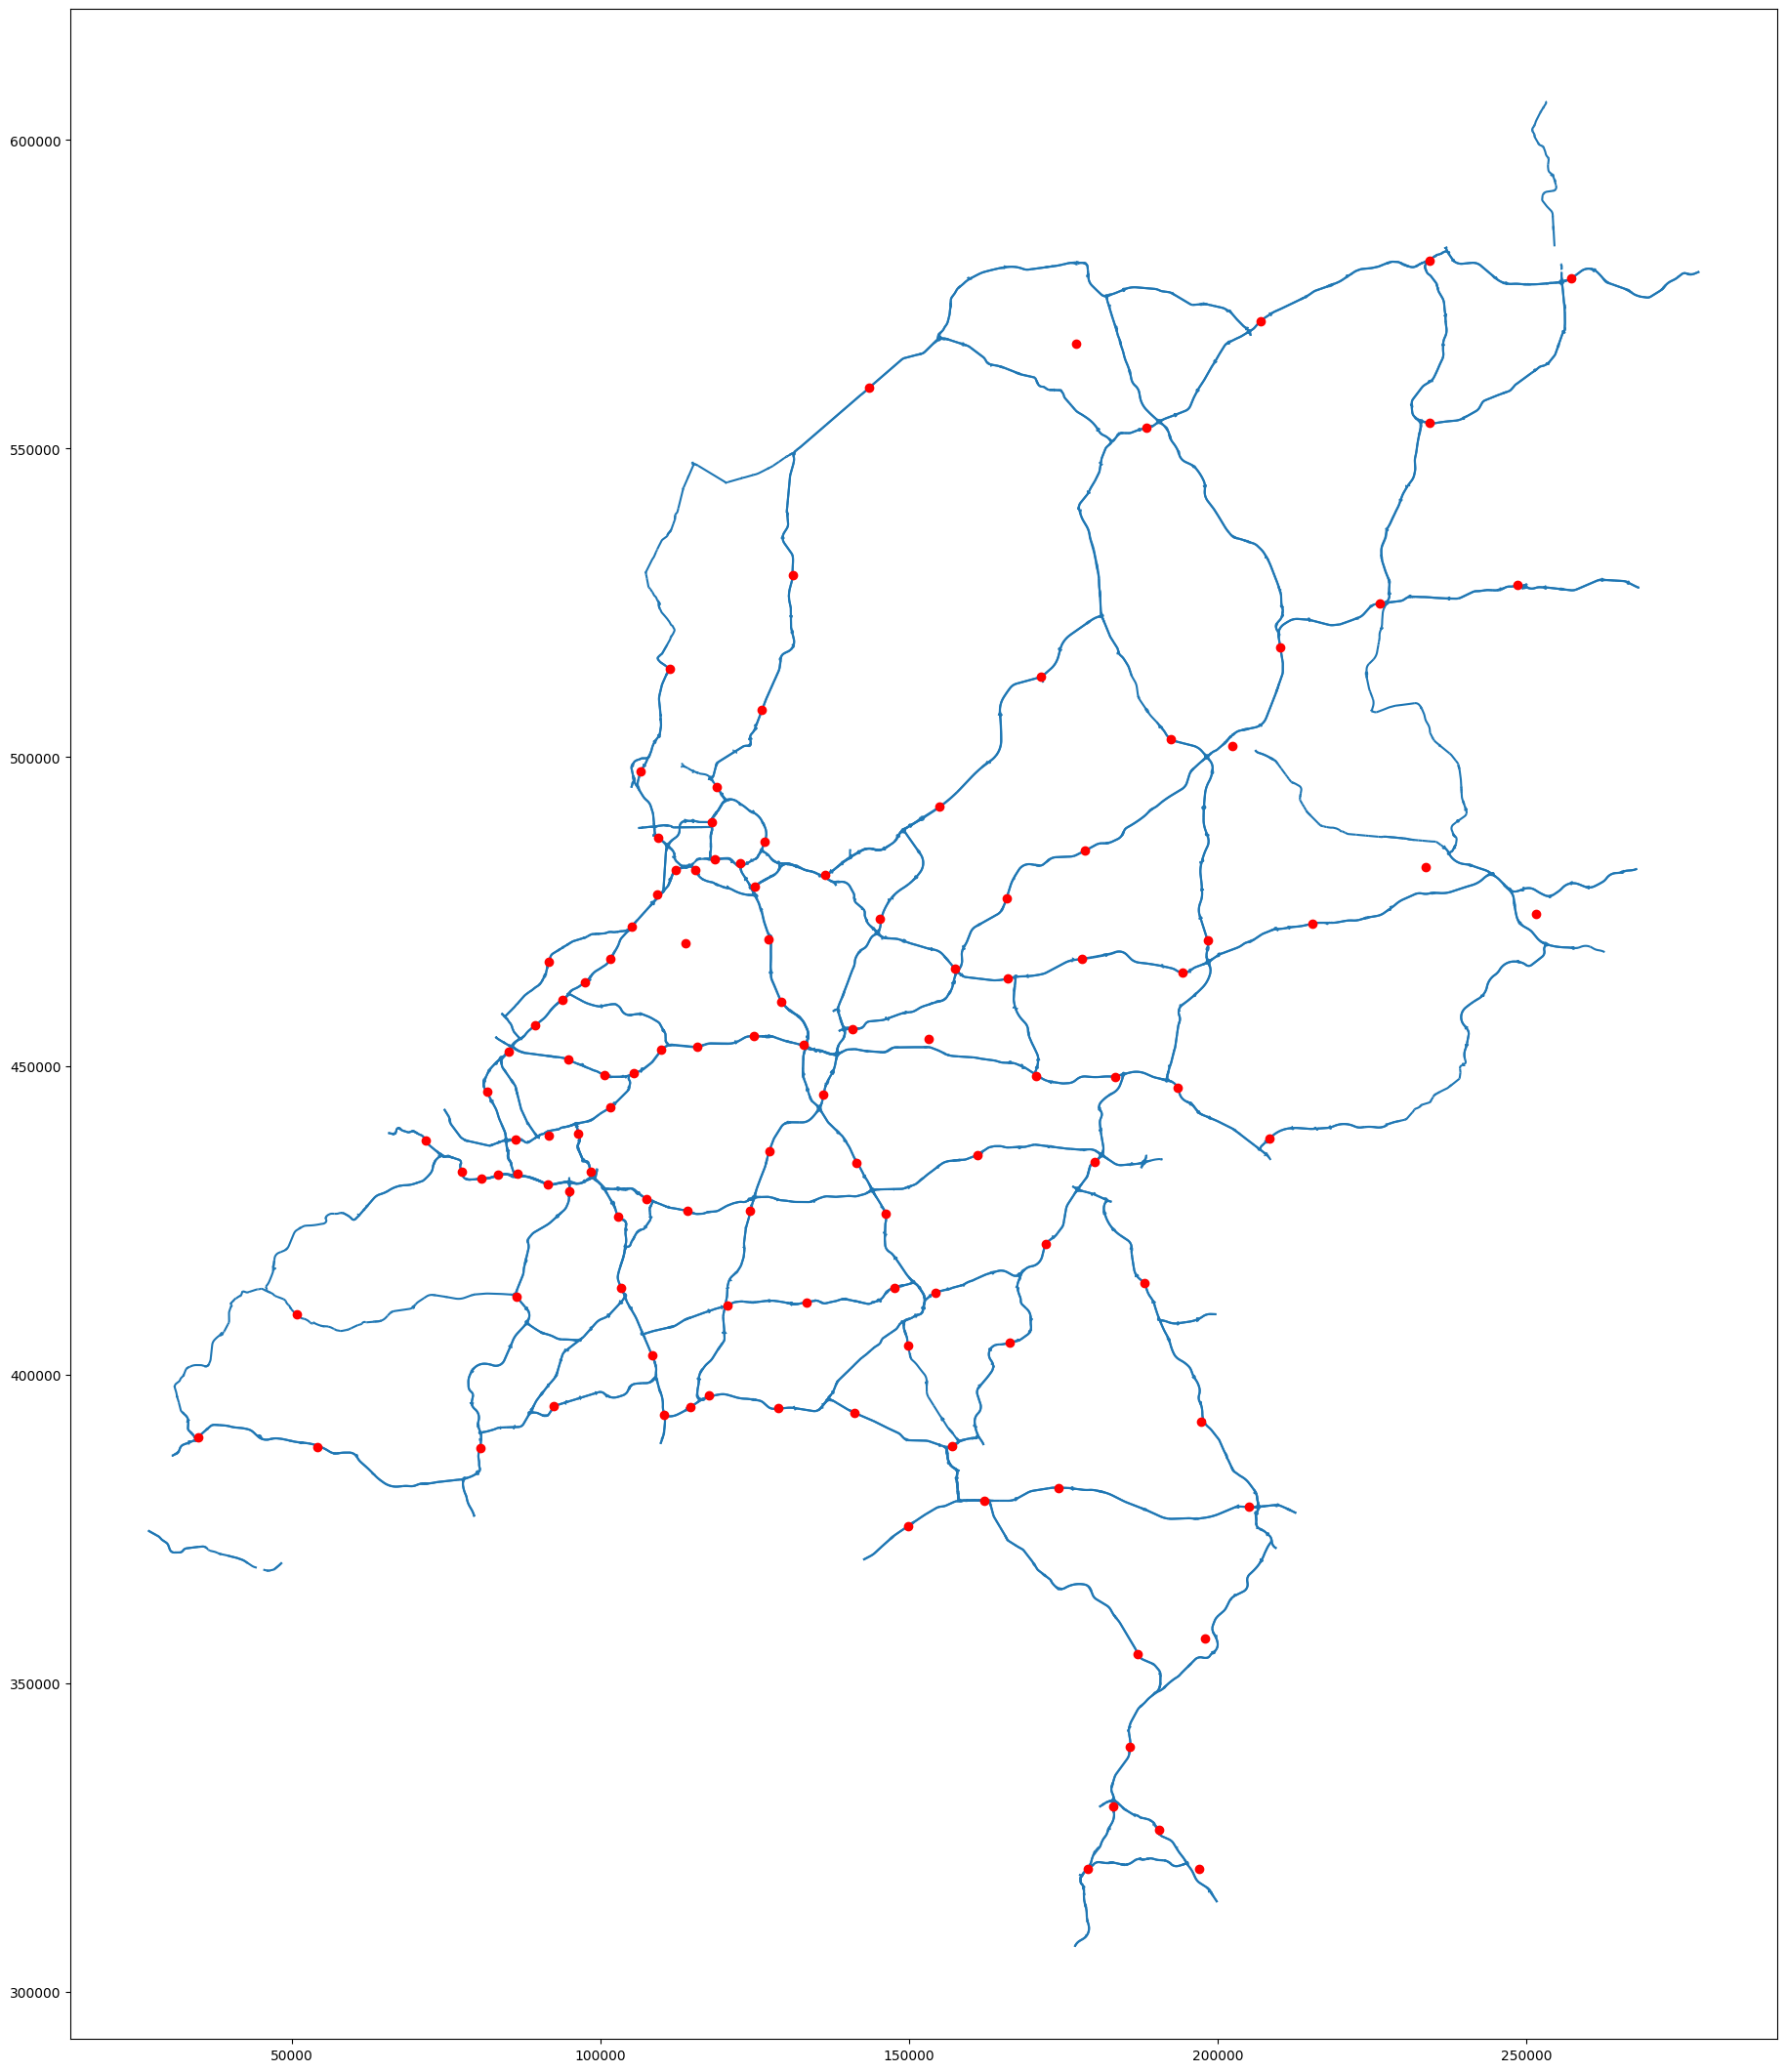

In [39]:
network_temp.plot(figsize=(30, 27))
plt.plot(new_rds['breedtegraad'], new_rds['lengtegraad'], 'ro');

#### 5.2. Plot incidents and centroids clustered

In [40]:
plt.figure(figsize=(150, 200))
plt.scatter(new_ill['primaire_locatie_lengtegraad'], new_ill['primaire_locatie_breedtegraad'],  
            marker = 'o', c=new_ill['medoid'].astype('category'), 
            cmap = customcmap, s=150, alpha=0.5)
plt.scatter(new_cc['lengtegraad'], new_cc['breedtegraad'],  
            marker = 's', s=2500, c=np.arange(0, 120, 1), 
            cmap = customcmap)

#### 5.3. Plot cluster sizes

In [30]:
number_inc_cluster = np.zeros(n)

for i in range(n):
    for j in range(len(new_ill['medoid'])):
        if int(new_ill['medoid'][j]) == i:
            number_inc_cluster[i] += 1
        else:
            number_inc_cluster[i] += 0

In [ ]:
network_temp.plot(figsize=(150, 200), linewidth=5)

plt.scatter(new_rds['breedtegraad'], new_rds['lengtegraad'],  
            marker = 's', s=10*number_inc_cluster, c=np.arange(0, 120, 1), 
            cmap = customcmap)

for t in range(n):
    plt.text(new_rds['breedtegraad'][t] + 1000, new_rds['lengtegraad'][t] + 1000, str(int(number_inc_cluster[t])), size=100)

#### 5.4. Plot average speed of clusters (large approximations)

In [32]:
v = 80 #km/h
factor = 1.3

In [33]:
transformer2 = Transformer.from_crs("EPSG:28992", "EPSG:4326")

dist1 = np.zeros((n, 2))
dist2 = np.zeros((len(new_ill['primaire_locatie_breedtegraad']), 2))

t41 = transformer2.transform(new_cc['breedtegraad'], new_cc['lengtegraad'])
t42 = transformer2.transform(new_ill['primaire_locatie_breedtegraad'], new_ill['primaire_locatie_lengtegraad'])

dist1[:, 0] = t41[0]
dist1[:, 1] = t41[1]
dist2[:, 0] = t42[0]
dist2[:, 1] = t42[1]

In [34]:
tot_time = np.zeros(n)
tot_points = np.zeros(n)
av_time = np.zeros(n)

for i in range(n):
    for j in range(len(new_ill['primaire_locatie_lengtegraad'])):
        if new_ill['medoid'][j] == i:
            absolute_dist = np.sqrt((dist2[:, 1][j] - dist1[:, 1][i])**2 + (dist2[:, 0][j] - dist1[:, 0][i])**2)
            tot_time[i] += absolute_dist * v * factor
            tot_points[i] += 1
        else:
            tot_points[i] += 0
    av_time[i] = tot_time[i] / tot_points[i] * 60 * 1000  # time in minutes

In [ ]:
network_temp.plot(figsize=(150, 200), linewidth=5)

plt.scatter(new_rds['breedtegraad'], new_rds['lengtegraad'],  
            marker = 's', s=10*number_inc_cluster, c=np.arange(0, 120, 1), 
            cmap = customcmap)

for t in range(n):
    plt.text(new_rds['breedtegraad'][t] + 1000, new_rds['lengtegraad'][t] + 1000, f'{av_time[t]:.2f}', size=100)